# Import Libraries

In [1]:
!pip install -q catboost

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)

# Load Data

In [4]:
TRAIN_PATH = 'data/train.txt'
TEST_PATH = 'data/test.txt'

EXPECTED_TRAIN_SIZE = 32561
EXPECTED_TEST_SIZE = 16281

COLUMNS = ['age', 'work_class', 'final_weight', 'education', 'education_num',
           'martial_status', 'occupation', 'relationship', 'race', 'sex',
           'cap_gain', 'cap_loss', 'hours_per_week', 'native_country']

NUMERICAL_COLS = ['age', 'final_weight', 'education_num', 'cap_gain',
                  'cap_loss', 'hours_per_week']

CATEGORICAL_COLS = ['work_class', 'education', 'martial_status', 'occupation',
                    'relationship', 'race', 'sex', 'native_country']

In [5]:
train_df = pd.read_csv(TRAIN_PATH, sep=', ', header=None, engine='python',
                       names=COLUMNS + ['target'])
if len(train_df) != EXPECTED_TRAIN_SIZE:
    print(f"Expected train size {EXPECTED_TRAIN_SIZE}, got {len(train_df)}.")

Expected train size 32561, got 32573.


In [6]:
test_df = pd.read_csv(TEST_PATH, sep=', ', header=None, engine='python',
                      skiprows=[0], names=COLUMNS)
if len(test_df) != EXPECTED_TEST_SIZE:
    print(f"Expected test size {EXPECTED_TEST_SIZE}, got {len(test_df)}.")

Expected test size 16281, got 16283.


# Exploratory Data Analysis

In [7]:
train_df.sample(5)

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
1409,33,Private,130021.0,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0.0,0.0,40,United-States,<=N
30356,23,Private,268525.0,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.0,0.0,48,United-States,<=N
16461,43,Private,145441.0,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,38,United-States,>N
1437,36,Federal-gov,218542.0,Assoc-acdm,12,Married-civ-spouse,Adm-clerical,Wife,White,Female,0.0,0.0,40,United-States,>N
6516,40,Private,175686.0,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0.0,0.0,40,United-States,<=N


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32573 non-null  object 
 1   work_class      32572 non-null  object 
 2   final_weight    32572 non-null  float64
 3   education       32572 non-null  object 
 4   education_num   32572 non-null  object 
 5   martial_status  32572 non-null  object 
 6   occupation      32572 non-null  object 
 7   relationship    32572 non-null  object 
 8   race            32572 non-null  object 
 9   sex             32572 non-null  object 
 10  cap_gain        32572 non-null  float64
 11  cap_loss        32572 non-null  float64
 12  hours_per_week  32572 non-null  object 
 13  native_country  32572 non-null  object 
 14  target          32571 non-null  object 
dtypes: float64(3), object(12)
memory usage: 3.7+ MB


In [9]:
train_df[train_df.isna().any(axis=1)]

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
16324,totally_legit_string,None,NaN,None,None,None,None,None,None,None,NaN,NaN,None,None,None
26556,-321,Private,2.312322e+17,Some-college,Machine-op-inspct,Sales,Husband,White,Other,0,-1.0,-444.0,United-States,>N,None


## Target

In [10]:
column = 'target'

In [11]:
# Are there any incorrect values in train target data?
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

target column value counts:
<=N    24720
>N      7851
NaN        2
Name: target, dtype: int64


We can see two things:<br>
1. There are 2 NaN values in target column.
2. There is a significant class imbalance in train data. We'll have to take that into account during dataset splitting and model evaluation.

Let's look at the entries with NaN targets:

In [12]:
train_df[train_df[column].isna()]

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
16324,totally_legit_string,None,NaN,None,None,None,None,None,None,None,NaN,NaN,None,None,None
26556,-321,Private,2.312322e+17,Some-college,Machine-op-inspct,Sales,Husband,White,Other,0,-1.0,-444.0,United-States,>N,None


These rows are obviously trash rows, we can just drop them.

In [13]:
print(f"train_df size: {len(train_df)}")
print(f'Dropping {len(train_df[train_df[column].isna()])} row(s).')
train_df.dropna(subset=[column], inplace=True)
print(f"train_df size: {len(train_df)}")

train_df size: 32573
Dropping 2 row(s).
train_df size: 32571


Now let's convert target column into binary representation.

In [14]:
TARGET_DICT = {
    '<=N': 0,
    '>N': 1,
}

INV_TARGET_DICT = {
    v: k for k, v in TARGET_DICT.items()
}

In [15]:
train_df[column] = train_df[column].map(TARGET_DICT).astype(np.uint8)
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

target column value counts:
0    24720
1     7851
Name: target, dtype: int64


In [16]:
pos_class_ratio = len(train_df[train_df[column] == 1]) / len(train_df)
print(f'Positive class ratio: {pos_class_ratio:.4f}.')

Positive class ratio: 0.2410.


## age

In [17]:
column = 'age'

train_df[column] = train_df[column].astype(np.uint8)

In [18]:
print(f'{column} column values:')
print(train_df[column].describe())

age column values:
count    32571.000000
mean        38.570108
std         13.654222
min          1.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


All of the values look fine, except for the age of 1. What's in there?

In [19]:
train_df[train_df[column] == 1]

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
26557,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26558,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26559,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26560,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26561,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26562,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26563,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26564,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26565,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1
26566,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,1


These rows are also trashy (apart from the age, look at those `hours_per_week` values!). Let's drop them:

In [20]:
print(f'train_df size: {len(train_df)}.')
print(f'Dropping {len(train_df[train_df[column] == 1])} row(s).')
train_df = train_df[train_df[column].values != 1]
print(f'train_df size: {len(train_df)}.')

train_df size: 32571.
Dropping 10 row(s).
train_df size: 32561.


In [21]:
print(train_df[column].describe())

count    32561.000000
mean        38.581647
std         13.640433
min         17.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64


That's better!

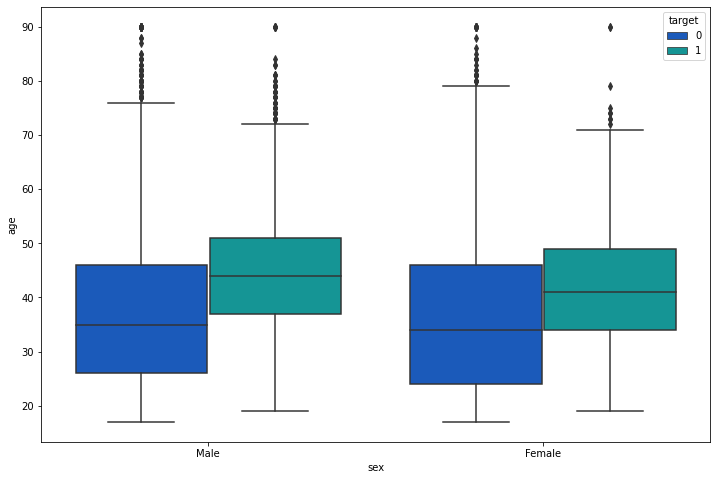

In [22]:
sns.boxplot(x='sex', y='age', hue='target', data=train_df, palette='winter');

## work_class

In [23]:
column = 'work_class'

In [24]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

work_class column value counts:
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: work_class, dtype: int64


The column looks fine.

Let's also check that test data has the same values as train data:

In [25]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None, 'PRIVATE'}


Whoops! There's a value that seems like a misspelled value from train data that we can replace:

In [26]:
test_df.loc[test_df[column] == 'PRIVATE', column] = 'Private'
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


As for NaN values, we'll deal with them later with the help of Imputers.

## final_weight

In [27]:
column = 'final_weight'

In [28]:
train_df[column].describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: final_weight, dtype: float64

In [29]:
train_df[train_df[column].isna()]

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target


In [30]:
test_df[column].describe()

count    1.628200e+04
mean     1.894227e+05
std      1.057246e+05
min     -2.132141e+04
25%      1.166768e+05
50%      1.778295e+05
75%      2.383840e+05
max      1.490400e+06
Name: final_weight, dtype: float64

## education

In [31]:
column = 'education'

In [32]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

education column value counts:
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64


In [33]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## education_num

In [34]:
column = 'education_num'

train_df[column] = train_df[column].astype(np.uint8)

In [35]:
print(f'{column} column value counts:')

print(train_df[column].value_counts(dropna=False))

education_num column value counts:
9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education_num, dtype: int64


In [36]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{nan, 102302103210.0}


There's a very suspicious value of 102302103210. Let's look at it more closely:

In [37]:
test_df[test_df[column] == 102302103210.0]

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country
14154,-10,Private,-21321.414,HS-grad,1.023021e+11,Divorced,Sales,Husband,White,Male,12.0,32.0,-321321421.0,United-States


Turns out there's some trash data in test as well. We can't expect good predictions for this sample anyway, so we can either leave it as is, or to replace bad values according to some strategy (mean/median/most_frequent/etc.). Here, we'll follow the first option and just ignore such samples.

## martial_status

In [38]:
column = 'martial_status'

In [39]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

martial_status column value counts:
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: martial_status, dtype: int64


In [40]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## occupation

In [41]:
column = 'occupation'

In [42]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

occupation column value counts:
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


In [43]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## relationship

In [44]:
column = 'relationship'

In [45]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

relationship column value counts:
Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


In [46]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## race

In [47]:
column = 'race'

In [48]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

race column value counts:
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


In [49]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## sex

In [50]:
column = 'sex'

In [51]:
print(f'{column} column value counts:')
print(train_df[column].value_counts(dropna=False))

sex column value counts:
Male      21790
Female    10771
Name: sex, dtype: int64


In [52]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## cap_gain

In [53]:
column = 'cap_gain'

In [54]:
print(f'{column} column value counts:')
print(train_df[column].describe())

cap_gain column value counts:
count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: cap_gain, dtype: float64


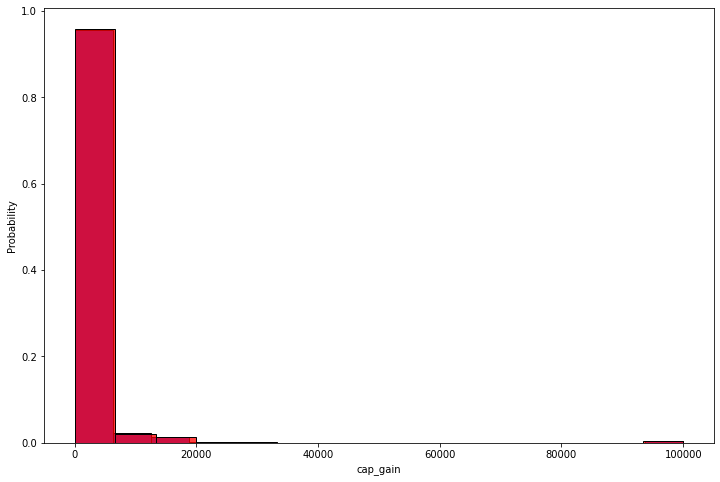

In [55]:
sns.histplot(train_df[column], stat='probability', color='b');
sns.histplot(test_df[column], stat='probability', color='r');

In [56]:
train_df[column].corr(train_df['target'])

0.2233288181953836

## cap_loss

In [57]:
column = 'cap_loss'

In [58]:
print(f'{column} column value counts:')
print(train_df[column].describe())

cap_loss column value counts:
count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: cap_loss, dtype: float64


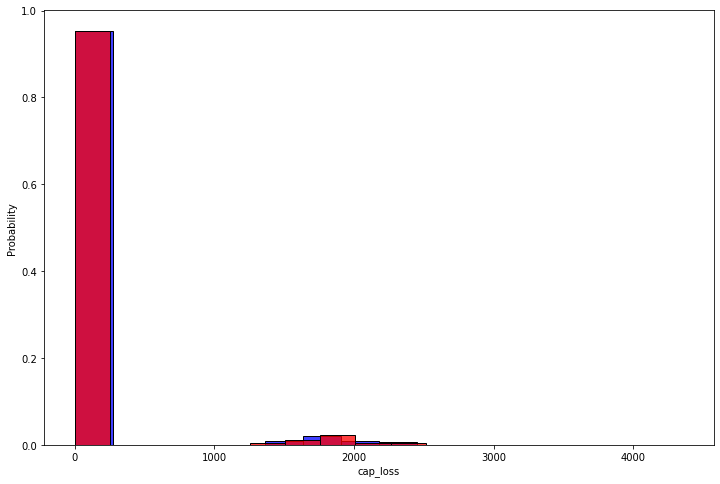

In [59]:
sns.histplot(train_df[column], stat='probability', color='b');
sns.histplot(test_df[column], stat='probability', color='r');

In [60]:
train_df[column].corr(train_df['target'])

0.15052631177035383

## hours_per_week

In [61]:
column = 'hours_per_week'

train_df[column] = train_df[column].astype(np.uint8)

In [62]:
print(f'{column} column info:')
print(train_df[column].describe())

hours_per_week column info:
count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64


## native_country

In [63]:
column = 'native_country'

In [64]:
print(f'{column} column info:')
print(train_df[column].value_counts(dropna=False))

native_country column info:
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31


In [65]:
print(set(test_df[column].unique()) - set(train_df[column].unique()))

{None}


## Statistics

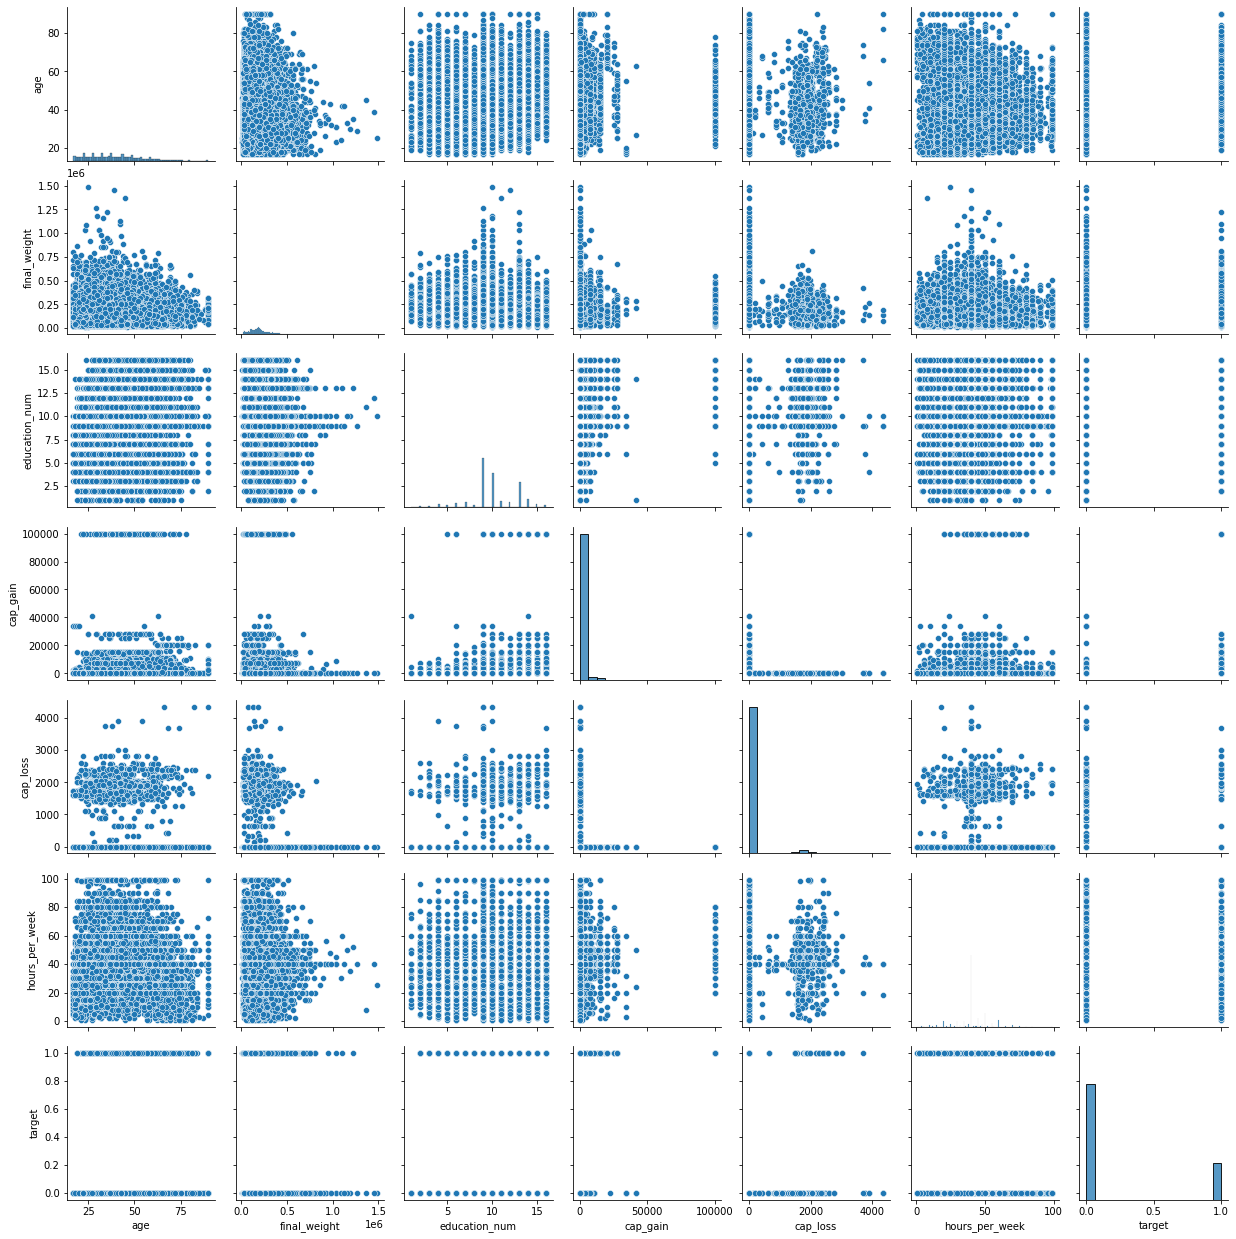

In [66]:
sns.pairplot(train_df);

Let's use LabelEncoder to build the full cross-correlation matrix.

In [67]:
train_df_copy = train_df.copy()

label_encoder = LabelEncoder()

for col in CATEGORICAL_COLS:
    train_df_copy[col] = label_encoder.fit_transform(train_df_copy[col])

In [68]:
train_df_copy.sample(5)

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
6176,27,4,269354.0,9,13,2,12,0,4,1,0.0,0.0,25,0,0
9885,68,0,76371.0,11,9,2,0,0,4,1,0.0,0.0,35,39,0
28617,51,6,290688.0,4,3,2,3,0,4,1,0.0,0.0,40,39,0
30271,39,1,363630.0,11,9,2,1,0,2,1,7688.0,0.0,52,39,1
28195,32,4,299635.0,15,10,2,4,0,4,1,0.0,0.0,50,11,0


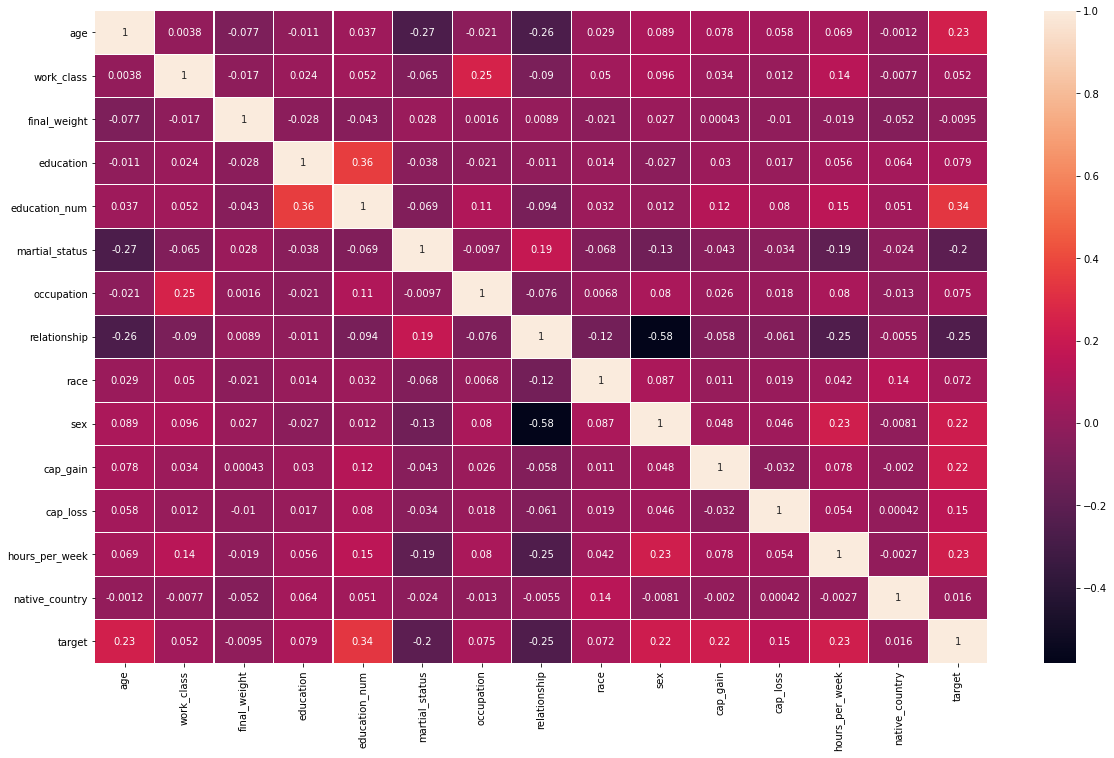

In [69]:
plt.figure(figsize=(20, 12))
sns.heatmap(train_df_copy.corr(), annot=True, linewidths=0.1);

## Test Data

In [70]:
test_df.sample(5)

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country
3310,29,Private,89598.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,2057.0,35.0,United-States
1321,62,Local-gov,106069.0,7th-8th,4.0,Married-civ-spouse,Craft-repair,Husband,White,Male,0.0,0.0,40.0,United-States
3869,51,Private,196828.0,Some-college,10.0,Divorced,Sales,Not-in-family,White,Female,0.0,0.0,38.0,United-States
8257,17,Local-gov,140240.0,11th,7.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,20.0,United-States
6239,23,Private,238917.0,5th-6th,3.0,Never-married,Handlers-cleaners,Other-relative,White,Male,0.0,0.0,40.0,El-Salvador


In [71]:
def validate_numeric(value: str) -> float:
    '''Function to catch bad values in numeric types.'''
    try:
        return float(value)
    except ValueError:
        return None

In [72]:
for col in NUMERICAL_COLS:
    test_df[col] = test_df[col].apply(validate_numeric)

In [73]:
test_df[test_df.isna().any(axis=1)]

,age,work_class,final_weight,education,education_num,martial_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country
12513,NaN,None,NaN,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None


# **Pipeline**

In [76]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

In [77]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y,
                                                      test_size=0.15,
                                                      stratify=y,
                                                      random_state=4)

In [78]:
print(f'x_train size: {len(x_train)}.')

x_train size: 27676.


In [79]:
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid,
                                                    test_size=0.2,
                                                    stratify=y_valid,
                                                    random_state=4)

In [80]:
print(f'x_valid size: {len(x_valid)}.')
print(f'x_test  size: {len(x_test)}.')

x_valid size: 3908.
x_test  size: 977.


## **Baseline**

Let's try to always predict the positive class.

In [81]:
y_pred = np.ones_like(y_valid)
print(f'F1-score: {f1_score(y_valid, y_pred)}')

F1-score: 0.38812126211590015


Now let's just randomly predict the positive target class with probability equal to the posiive class ratio in the train data.

In [82]:
p = len(train_df[train_df['target'] == 1]) / len(train_df)
print(f'Positive class ratio: {p:.2f}.')

y_pred = np.random.binomial(n=1, p=p, size=len(y_valid))
print(f'F1-score: {f1_score(y_valid, y_pred)}.')

Positive class ratio: 0.24.
F1-score: 0.24008243173621846.


As expected. Now let's try to apply Machine Learning and achieve better results.

## **CatBoost**

In [83]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, NUMERICAL_COLS),
        ('cat', categorical_transformer, CATEGORICAL_COLS)
    ])

In [84]:
model = CatBoostClassifier(iterations=3000,
                           learning_rate=1e-2,
                           loss_function='Logloss',
                           eval_metric='F1',
                           use_best_model=True,
                           random_state=4)

In [85]:
# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

pipeline['preprocessor'].fit(x_train)

# Preprocessing of training data, fit model
pipeline.fit(x_train, y_train,
             model__eval_set=(preprocessor.transform(x_valid), y_valid))

# Preprocess the holdout test data and get predictions
y_pred = pipeline.predict(x_test)

# Evaluate the model
score = f1_score(y_test, y_pred)
print('F1:', score)

0:	learn: 0.6401799	test: 0.6372606	best: 0.6372606 (0)	total: 62.5ms	remaining: 3m 7s
1:	learn: 0.6359953	test: 0.6362039	best: 0.6372606 (0)	total: 75.5ms	remaining: 1m 53s
2:	learn: 0.6429479	test: 0.6434885	best: 0.6434885 (2)	total: 90.2ms	remaining: 1m 30s
3:	learn: 0.6356131	test: 0.6391753	best: 0.6434885 (2)	total: 104ms	remaining: 1m 17s
4:	learn: 0.6381953	test: 0.6419162	best: 0.6434885 (2)	total: 117ms	remaining: 1m 9s
5:	learn: 0.6403351	test: 0.6464286	best: 0.6464286 (5)	total: 131ms	remaining: 1m 5s
6:	learn: 0.6372125	test: 0.6442308	best: 0.6464286 (5)	total: 144ms	remaining: 1m 1s
7:	learn: 0.6402601	test: 0.6460072	best: 0.6464286 (5)	total: 158ms	remaining: 58.9s
8:	learn: 0.6352839	test: 0.6425993	best: 0.6464286 (5)	total: 171ms	remaining: 56.7s
9:	learn: 0.6353370	test: 0.6392749	best: 0.6464286 (5)	total: 184ms	remaining: 54.9s
10:	learn: 0.6377238	test: 0.6442308	best: 0.6464286 (5)	total: 197ms	remaining: 53.6s
11:	learn: 0.6342101	test: 0.6384010	best: 0.64

In [86]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       742
           1       0.83      0.60      0.70       235

    accuracy                           0.87       977
   macro avg       0.86      0.78      0.81       977
weighted avg       0.87      0.87      0.87       977



Overall, we managed to increase the value of F1-score almost twice compared to the best baseline.

# **Cross-Validation**

In [87]:
# scores = cross_val_score(
#     pipeline, x_train, y_train,
#     cv=5,
#     scoring='f1',
#     fit_params={
#         'model__eval_set': (preprocessor.transform(x_valid), y_valid),
#     }
# )

# print("F1 scores:\n", scores)

# **Making Predictions**

In [88]:
test_pred = pipeline.predict(test_df)

In [89]:
pred_df = pd.DataFrame(test_pred, columns=['target'])
pred_df['target'] = pred_df['target'].map(INV_TARGET_DICT)

In [90]:
OUTPUT_PATH = 'output.txt'


with open(TEST_PATH, 'r') as fin, open(OUTPUT_PATH, 'w') as fout:
    in_lines = fin.readlines()
    out_lines = [in_lines[0]]

    for line, pred in zip(in_lines[1:], pred_df['target'].values):
        out_lines.append(line.rstrip() + ', ' + pred + '\n')

    fout.writelines(out_lines)